In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from nltk import word_tokenize
from sklearn.feature_extraction import text
import urllib.request, json 

In [2]:
from sklearn.cluster import KMeans, MiniBatchKMeans, MeanShift
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

In [3]:
from langdetect import detect

In [7]:
from scipy.spatial.distance import cdist
import matplotlib.pylab as plt
from sklearn import metrics

## Define helper functions, initialize vectorizer

In [8]:
def list_to_string(df):    
    return ' '.join(df['text'])

In [9]:
def extract_language(df):    
    df['language'] = detect(df['text_concat'])
    return df

In [10]:
def extract_json(df):    
    df['course_id'] = df.values[0]['course_id']
    df['title'] = df.values[0]['title']
    df['text_concat'] = df.values[0]['description'] + ' ' + df.values[0]['subtitle'] + ' ' + df.values[0]['what_you_will_learn']
    df['url'] = df.values[0]['course_about_uri']
    df['language'] = detect(df['text_concat'])
    return df

In [11]:
# define stop words and add them to the standard english list

additional_stop_words = [
    'university',
    'college',
    'partner',
    'closely',
    'readings',
    'reading',
    'requires',
    'require',
    'title',
    'provider',
    'section',
    'video',
    'videos',
    'problem',
    'problems',
    'learners',
    'define',
    'able',
    'exam',
    'duke',
    'week',
    'teach',
    'learn',
    'goes',
    'description',
    'school',
    'illinois',
    'urbana',
    'duke',
    'champaign',
    'mit',
    'stanford',
    'harvard',
    'look',
    'null',
    'li',
    'em',
    'ul',
    'edx',
    'harvardx',
    'span',
    'href',
    '_blank',
    'mitx',
    'likely',
    'use',
    'like',
    'northwestern',
    'mooc',
    'enroll',
    'enrolling',
    'course',
    'certificate',
    'verified',
    'california',
    'san diego',
    'michigan',
    'll',
    'xseries',
    'micromasters',
    'actual',
    'actually',
    'teacher',
    'teaches',
    'edu',
    'educators',
    'work',
    'effort'
]

stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words)

In [12]:
# initialize vectorizer. use custom token pattern to remove numeric characters

count_vect = TfidfVectorizer(stop_words = stop_words, 
                             ngram_range = (1,3),
                            token_pattern='(?u)\\b[a-zA-z][a-zA-z]+\\b',
                            smooth_idf=True,
                            min_df = 0.1,
                            max_df = 0.8)

## edX
* * *

#### Load in data, extract text, and clean up df

In [13]:
with urllib.request.urlopen("https://www.edx.org/api/catalog/v2/courses/") as url:
    edx_df = json.loads(url.read().decode())

edx_df = pd.DataFrame(edx_df)
edx_df = edx_df.apply(extract_json, axis=1)
edx_df = edx_df.set_index('title')

In [14]:
edx_df_english = edx_df[edx_df['language']=='en']
edx_df_english['provider'] = 'edx'

/Users/adleyhemphill/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## Udacity + Coursera
* * *

Read in data from the scrapes, extract the text and prep the df

Concatenate the two dfs together, set our index, and attempt to guess the language of the text

In [19]:
udacity_df = pd.read_json('/Users/adleyhemphill/udacity_courses.json')
udacity_df['text_concat'] = udacity_df.apply(list_to_string, axis=1)
udacity_df = udacity_df.groupby(['title','url'])['text_concat'].apply(
    lambda text_concat: "%s" % ', '.join(text_concat)).reset_index()
udacity_df['provider'] = 'udacity'
udacity_df = udacity_df.set_index(['title','provider'])

In [20]:
coursera_df = pd.read_json('/Users/adleyhemphill/coursera_courses.json')
coursera_df['provider'] = 'coursera'
coursera_df = coursera_df.set_index(['title','provider'])
coursera_df['text_concat'] = coursera_df.apply(list_to_string, axis=1)

In [21]:
udacity_coursera_df = pd.concat([coursera_df.reset_index()[['title','provider','url','text_concat']],
         udacity_df.reset_index()[['title','provider','url','text_concat']]])

udacity_coursera_df = udacity_coursera_df.set_index(['title','provider'])

udacity_coursera_df = udacity_coursera_df.apply(extract_language, axis=1)

Filter for English only (for now)

In [22]:
udacity_coursera_english_df = udacity_coursera_df[udacity_coursera_df.language=='en']

TFIDF the combined df, get the feature names, and create a vocabulary df

In [109]:
udacity_coursera_X_train_counts = count_vect.fit_transform(udacity_coursera_english_df.text_concat)

col_names = count_vect.get_feature_names()

udacity_coursera_vocab = pd.DataFrame(udacity_coursera_X_train_counts.toarray(), 
                                      columns = col_names).set_index(udacity_coursera_english_df.index)

KMeans cluster on the vocab df. Add the cluster to the original df

In [110]:
km_udacity_coursera = KMeans(n_clusters=25, 
                             init='k-means++',
                             max_iter=100, 
                             n_init=1)

km_udacity_coursera.fit(udacity_coursera_vocab)

udacity_coursera_vocab['cluster_km'] = km_udacity_coursera.labels_

Examples of:

- top words per course
- courses associated with a given cluster
- top words associated with a given cluster

In [111]:
udacity_coursera_vocab.T.ix[:,205].sort_values(ascending=False)

cluster_km      22.000000
material         0.368365
information      0.354673
introduction     0.285223
prepare          0.244048
decisions        0.238217
value            0.230858
cover            0.219596
analyze          0.214269
discuss          0.203253
complete         0.201926
start            0.184346
skills           0.158465
help             0.154566
understand       0.153154
make             0.149065
using            0.145816
today            0.124364
company          0.123176
life             0.116398
future           0.114483
review           0.106623
various          0.104402
types            0.103221
way              0.095835
based            0.093596
questions        0.092878
analysis         0.092173
time             0.088828
final            0.087567
                  ...    
know             0.000000
key              0.000000
just             0.000000
issues           0.000000
needs            0.000000
online           0.000000
opportunity      0.000000
order       

In [112]:
udacity_coursera_vocab.reset_index()[
    udacity_coursera_vocab.reset_index()['cluster_km']==1][['title','provider']].title.values

array(['Design Thinking for Innovation', 'Introduction to UI Design',
       'Ideas from the History of Graphic Design',
       'Fundamentals of Graphic Design',
       'User Interface Design Specialization',
       'Introduction to User Experience Design ',
       'Graphic Design Specialization', 'Input and Interaction',
       'Graphic Design', 'Leadership Through Design Innovation',
       'Design Principles: an Introduction',
       'Designing, Running, and Analyzing Experiments',
       'User Experience: Research & Prototyping',
       'Interaction Design Specialization', 'Information Design',
       'User Research and Design', 'Prototyping and Design',
       'Usable Security', 'Hardware Security', 'VLSI CAD Part I: Logic',
       'Digital Manufacturing Commons (opendmc.org)',
       'VLSI CAD Part II: Layout',
       'Digital Manufacturing & Design Technology  Specialization',
       'Principles of Game Design', 'Character Design for Video Games',
       'Game Design: Art and Co

In [114]:
order_centroids = km_udacity_coursera.cluster_centers_.argsort()[:, ::-1] 

for i in range(24):
    print("Cluster %d words:" % i, end='')
    
    for i in order_centroids[i, :5]: #replace 6 with n words per cluster
        print(' %s' % col_names[i], end=',')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Cluster 0 words: programming, data, class, language, program,

Cluster 1 words: design, user, principles, concepts, techniques,

Cluster 2 words: life, human, modern, explore, discuss,

Cluster 3 words: test, analysis, data, research, level,

Cluster 4 words: english, free, language, practice, skills,

Cluster 5 words: communication, english, business, skills, effective,

Cluster 6 words: industry, business, management, key, approach,

Cluster 7 words: web, application, data, applications, user,

Cluster 8 words: computer, world, software, real, science,

Cluster 9 words: language, content, students, learning, state,

Cluster 10 words: module, understanding, welcome, time, state,

Cluster 11 words: systems, software, techniques, using, programming,

Cluster 12 words: writing, write, research, english, good,

Cluster 13 words: social, content, strategy, business, research,

Cluster 14 words: strategy, business, product, strategies, industry,

Cluster 15 words: business, module, skills, 

Let's use the clustering model we built from Udacity and Coursera to predict edX courses.

Define a new vectorizer with a vocabulary limited to that of Coursera and Udacity

In [118]:
edx_vectorizer_coursera_words = TfidfVectorizer(stop_words = stop_words, 
                             ngram_range = (1,2),
                            smooth_idf=True,
                            vocabulary = col_names)

Vectorize and extract the vocabulary

In [119]:
edx_X_train_counts = edx_vectorizer_coursera_words.fit_transform(edx_df_english.text_concat)

col_names = count_vect.get_feature_names()

edx_vocab = pd.DataFrame(edx_X_train_counts.toarray(), columns = col_names).set_index(edx_df_english.index)

Add the cluster to the original edX df, concat with Udacity and Coursera, and write to csv

In [120]:
edx_df_english['cluster_km'] = km_udacity_coursera.predict(edx_vocab)
edx_df_english['provider'] = 'edx'

/Users/adleyhemphill/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/adleyhemphill/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [121]:
edx_df_english.reset_index()

,title,items,course_id,text_concat,url,language,provider,cluster_km
0,Introduction to Marketing,"{'cid': 'v2_full_en:16781', 'current_language'...",course-v1:UBCx+Marketing1x+3T2015,<p>Marketing is a crucial function in all busi...,/course/introduction-marketing-ubcx-marketing1x,en,edx,14
1,Introduction to Computer Science,"{'cid': 'v2_full_en:1022', 'current_language':...",course-v1:HarvardX+CS50+X,"<p>This is <strong>CS50x</strong>, Harvard Uni...",/course/introduction-computer-science-harvardx...,en,edx,0
2,Basic Mandarin Chinese – Level 1,"{'cid': 'v2_full_en:19576', 'current_language'...",course-v1:MandarinX+MX101x+2T2016,<p>Introductory Mandarin is the first in a ser...,/course/basic-mandarin-chinese-level-1-mandari...,en,edx,9
3,Advanced Biorefinery,"{'cid': 'v2_full_en:25756', 'current_language'...",course-v1:WageningenX+BB03x+2T2017,<p>In a biorefinery a complex biobased feedsto...,/course/advanced-biorefinery-wageningenx-bb03x,en,edx,1
4,Best Practices for Project Management Success,"{'cid': 'v2_full_en:26161', 'current_language'...",course-v1:RITx+PM9002x+1T2017,<p>Project management plays a key role in supp...,/course/best-practices-project-management-ritx...,en,edx,23
5,CSS Basics,"{'cid': 'v2_full_en:32941', 'current_language'...",course-v1:W3Cx+CSS.0x+1T2017,"<p><img alt="""" class=""Image img__fid__92186 im...",/course/css-basics-w3cx-css-0x,en,edx,21
6,Financial Analysis for Decision Making: Fundin...,"{'cid': 'v2_full_en:27851', 'current_language'...",course-v1:BabsonX+BPET.FINx+2T2017,<p>How do you find the money necessary to effe...,/course/financial-analysis-decision-making-bab...,en,edx,15
7,Geoscience: the Earth and its Resources,"{'cid': 'v2_full_en:32766', 'current_language'...",course-v1:DelftX+GEO101x+2T2017,<p>Are you fascinated by Geosciences and willi...,/course/geoscience-earth-its-resources-delftx-...,en,edx,2
8,HTML5 Coding Essentials and Best Practices,"{'cid': 'v2_full_en:32956', 'current_language'...",course-v1:W3Cx+HTML5.1x+1T2017,"<p>HTML5 is the standard language of the Web, ...",/course/html5-coding-essentials-w3cx-html5-1x-2,en,edx,21
9,HTML5 and CSS Fundamentals,"{'cid': 'v2_full_en:32946', 'current_language'...",course-v1:W3Cx+HTML5.0x+1T2017,"<p><img alt="""" class=""image-style-large media-...",/course/html5-css-fundamentals-w3cx-html5-0x,en,edx,21


In [842]:
all_courses_out_df = pd.concat([edx_df_english.reset_index()[['title','provider','cluster_km']], 
                                                              udacity_coursera_vocab.reset_index(), 
                                                            ])

In [845]:
all_courses_out_df[['title','cluster_km','provider']].to_csv('./all_courses_out.csv')

## Clustering attempt 2

The results of that were...bad. Let's try combining all course providers together and clustering

In [25]:
combined_english_df = pd.concat([edx_df_english.reset_index()[['title','provider','text_concat']],
           udacity_coursera_english_df.reset_index()[['title', 'provider','text_concat']]])

In [123]:
combined_vect = TfidfVectorizer(stop_words = stop_words, 
                             ngram_range = (1,3),
                            token_pattern='(?u)\\b[a-zA-z][a-zA-z]+\\b',
                             min_df = 0.01,
                                max_df = 0.03)

In [124]:
# combined_X_train_counts = combined_vect.fit_transform(combined_english_df.text_concat)

# combined_col_names = combined_vect.get_feature_names()

# combined_vocab = pd.DataFrame(combined_X_train_counts.toarray(), columns = combined_col_names).set_index(combined_english_df.index)

With 6 clusters, the silhouette Coefficient: 0.737
With 8 clusters, the silhouette Coefficient: 0.678
With 10 clusters, the silhouette Coefficient: 0.637
With 12 clusters, the silhouette Coefficient: 0.520
With 14 clusters, the silhouette Coefficient: 0.569
With 16 clusters, the silhouette Coefficient: 0.392
With 18 clusters, the silhouette Coefficient: 0.460
With 20 clusters, the silhouette Coefficient: 0.468
With 22 clusters, the silhouette Coefficient: 0.373
With 24 clusters, the silhouette Coefficient: 0.373
With 26 clusters, the silhouette Coefficient: 0.267
With 28 clusters, the silhouette Coefficient: 0.303
With 30 clusters, the silhouette Coefficient: 0.247
With 32 clusters, the silhouette Coefficient: 0.261
With 34 clusters, the silhouette Coefficient: 0.247
With 36 clusters, the silhouette Coefficient: 0.224
With 38 clusters, the silhouette Coefficient: 0.227


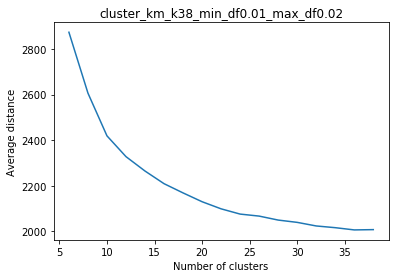


With 6 clusters, the silhouette Coefficient: 0.739
With 8 clusters, the silhouette Coefficient: 0.677
With 10 clusters, the silhouette Coefficient: 0.546
With 12 clusters, the silhouette Coefficient: 0.529
With 14 clusters, the silhouette Coefficient: 0.560
With 16 clusters, the silhouette Coefficient: 0.401
With 18 clusters, the silhouette Coefficient: 0.397
With 20 clusters, the silhouette Coefficient: 0.381
With 22 clusters, the silhouette Coefficient: 0.455
With 24 clusters, the silhouette Coefficient: 0.383
With 26 clusters, the silhouette Coefficient: 0.296
With 28 clusters, the silhouette Coefficient: 0.362
With 30 clusters, the silhouette Coefficient: 0.269
With 32 clusters, the silhouette Coefficient: 0.278
With 34 clusters, the silhouette Coefficient: 0.265
With 36 clusters, the silhouette Coefficient: 0.268
With 38 clusters, the silhouette Coefficient: 0.243


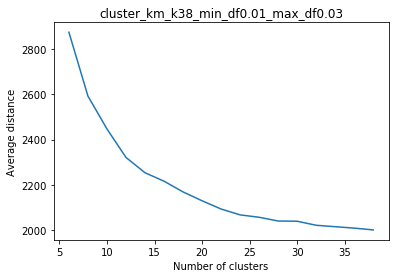


With 6 clusters, the silhouette Coefficient: 0.737
With 8 clusters, the silhouette Coefficient: 0.677
With 10 clusters, the silhouette Coefficient: 0.636
With 12 clusters, the silhouette Coefficient: 0.511
With 14 clusters, the silhouette Coefficient: 0.548
With 16 clusters, the silhouette Coefficient: 0.389
With 18 clusters, the silhouette Coefficient: 0.389
With 20 clusters, the silhouette Coefficient: 0.376
With 22 clusters, the silhouette Coefficient: 0.390
With 24 clusters, the silhouette Coefficient: 0.397
With 26 clusters, the silhouette Coefficient: 0.302
With 28 clusters, the silhouette Coefficient: 0.274
With 30 clusters, the silhouette Coefficient: 0.291
With 32 clusters, the silhouette Coefficient: 0.274
With 34 clusters, the silhouette Coefficient: 0.276
With 36 clusters, the silhouette Coefficient: 0.269
With 38 clusters, the silhouette Coefficient: 0.225


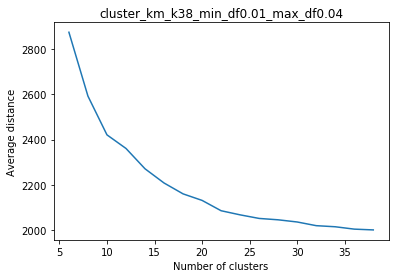


With 6 clusters, the silhouette Coefficient: 0.739
With 8 clusters, the silhouette Coefficient: 0.677
With 10 clusters, the silhouette Coefficient: 0.645
With 12 clusters, the silhouette Coefficient: 0.515
With 14 clusters, the silhouette Coefficient: 0.540
With 16 clusters, the silhouette Coefficient: 0.454
With 18 clusters, the silhouette Coefficient: 0.457
With 20 clusters, the silhouette Coefficient: 0.379
With 22 clusters, the silhouette Coefficient: 0.287
With 24 clusters, the silhouette Coefficient: 0.394
With 26 clusters, the silhouette Coefficient: 0.261
With 28 clusters, the silhouette Coefficient: 0.275
With 30 clusters, the silhouette Coefficient: 0.286
With 32 clusters, the silhouette Coefficient: 0.224
With 34 clusters, the silhouette Coefficient: 0.263
With 36 clusters, the silhouette Coefficient: 0.236
With 38 clusters, the silhouette Coefficient: 0.243


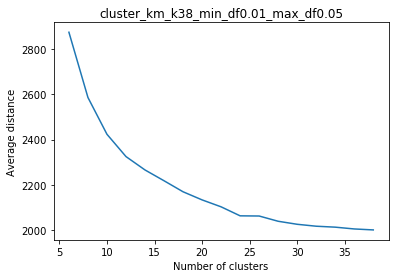


With 6 clusters, the silhouette Coefficient: 0.737
With 8 clusters, the silhouette Coefficient: 0.672
With 10 clusters, the silhouette Coefficient: 0.646
With 12 clusters, the silhouette Coefficient: 0.576
With 14 clusters, the silhouette Coefficient: 0.558
With 16 clusters, the silhouette Coefficient: 0.460
With 18 clusters, the silhouette Coefficient: 0.440
With 20 clusters, the silhouette Coefficient: 0.270
With 22 clusters, the silhouette Coefficient: 0.280
With 24 clusters, the silhouette Coefficient: 0.302
With 26 clusters, the silhouette Coefficient: 0.290
With 28 clusters, the silhouette Coefficient: 0.264
With 30 clusters, the silhouette Coefficient: 0.245
With 32 clusters, the silhouette Coefficient: 0.270
With 34 clusters, the silhouette Coefficient: 0.270
With 36 clusters, the silhouette Coefficient: 0.226
With 38 clusters, the silhouette Coefficient: 0.207


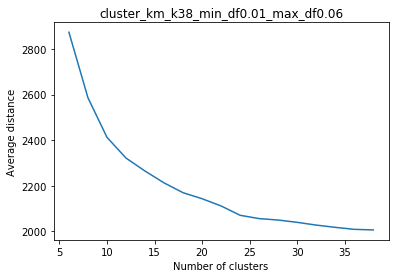


With 6 clusters, the silhouette Coefficient: 0.729
With 8 clusters, the silhouette Coefficient: 0.677
With 10 clusters, the silhouette Coefficient: 0.639
With 12 clusters, the silhouette Coefficient: 0.578
With 14 clusters, the silhouette Coefficient: 0.536
With 16 clusters, the silhouette Coefficient: 0.466
With 18 clusters, the silhouette Coefficient: 0.390
With 20 clusters, the silhouette Coefficient: 0.359
With 22 clusters, the silhouette Coefficient: 0.276
With 24 clusters, the silhouette Coefficient: 0.285
With 26 clusters, the silhouette Coefficient: 0.302
With 28 clusters, the silhouette Coefficient: 0.287
With 30 clusters, the silhouette Coefficient: 0.293
With 32 clusters, the silhouette Coefficient: 0.257
With 34 clusters, the silhouette Coefficient: 0.241
With 36 clusters, the silhouette Coefficient: 0.232
With 38 clusters, the silhouette Coefficient: 0.212


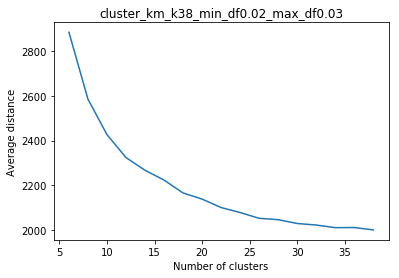


With 6 clusters, the silhouette Coefficient: 0.734
With 8 clusters, the silhouette Coefficient: 0.677
With 10 clusters, the silhouette Coefficient: 0.641
With 12 clusters, the silhouette Coefficient: 0.525
With 14 clusters, the silhouette Coefficient: 0.555
With 16 clusters, the silhouette Coefficient: 0.469
With 18 clusters, the silhouette Coefficient: 0.438
With 20 clusters, the silhouette Coefficient: 0.384
With 22 clusters, the silhouette Coefficient: 0.281
With 24 clusters, the silhouette Coefficient: 0.372
With 26 clusters, the silhouette Coefficient: 0.302
With 28 clusters, the silhouette Coefficient: 0.302
With 30 clusters, the silhouette Coefficient: 0.248
With 32 clusters, the silhouette Coefficient: 0.262
With 34 clusters, the silhouette Coefficient: 0.245
With 36 clusters, the silhouette Coefficient: 0.262
With 38 clusters, the silhouette Coefficient: 0.244


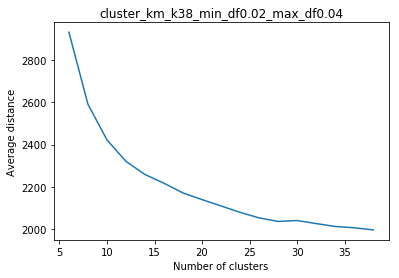


With 6 clusters, the silhouette Coefficient: 0.738
With 8 clusters, the silhouette Coefficient: 0.686
With 10 clusters, the silhouette Coefficient: 0.645
With 12 clusters, the silhouette Coefficient: 0.581
With 14 clusters, the silhouette Coefficient: 0.553
With 16 clusters, the silhouette Coefficient: 0.410
With 18 clusters, the silhouette Coefficient: 0.366
With 20 clusters, the silhouette Coefficient: 0.431
With 22 clusters, the silhouette Coefficient: 0.293
With 24 clusters, the silhouette Coefficient: 0.418
With 26 clusters, the silhouette Coefficient: 0.286
With 28 clusters, the silhouette Coefficient: 0.305
With 30 clusters, the silhouette Coefficient: 0.280
With 32 clusters, the silhouette Coefficient: 0.271
With 34 clusters, the silhouette Coefficient: 0.254
With 36 clusters, the silhouette Coefficient: 0.222
With 38 clusters, the silhouette Coefficient: 0.240


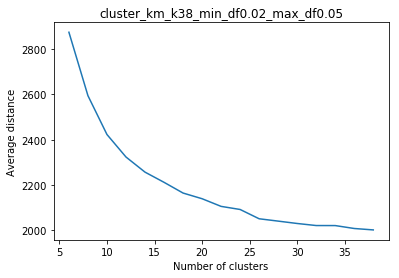


With 6 clusters, the silhouette Coefficient: 0.739
With 8 clusters, the silhouette Coefficient: 0.682
With 10 clusters, the silhouette Coefficient: 0.648
With 12 clusters, the silhouette Coefficient: 0.607
With 14 clusters, the silhouette Coefficient: 0.491
With 16 clusters, the silhouette Coefficient: 0.459
With 18 clusters, the silhouette Coefficient: 0.391
With 20 clusters, the silhouette Coefficient: 0.277
With 22 clusters, the silhouette Coefficient: 0.379
With 24 clusters, the silhouette Coefficient: 0.393
With 26 clusters, the silhouette Coefficient: 0.264
With 28 clusters, the silhouette Coefficient: 0.381
With 30 clusters, the silhouette Coefficient: 0.280
With 32 clusters, the silhouette Coefficient: 0.267
With 34 clusters, the silhouette Coefficient: 0.241
With 36 clusters, the silhouette Coefficient: 0.237
With 38 clusters, the silhouette Coefficient: 0.257


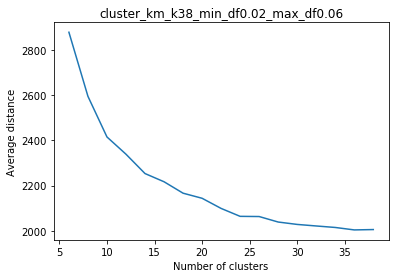


With 6 clusters, the silhouette Coefficient: 0.739
With 8 clusters, the silhouette Coefficient: 0.672
With 10 clusters, the silhouette Coefficient: 0.633
With 12 clusters, the silhouette Coefficient: 0.576
With 14 clusters, the silhouette Coefficient: 0.423
With 16 clusters, the silhouette Coefficient: 0.394
With 18 clusters, the silhouette Coefficient: 0.433
With 20 clusters, the silhouette Coefficient: 0.386
With 22 clusters, the silhouette Coefficient: 0.295
With 24 clusters, the silhouette Coefficient: 0.278
With 26 clusters, the silhouette Coefficient: 0.280
With 28 clusters, the silhouette Coefficient: 0.279
With 30 clusters, the silhouette Coefficient: 0.279
With 32 clusters, the silhouette Coefficient: 0.253
With 34 clusters, the silhouette Coefficient: 0.263
With 36 clusters, the silhouette Coefficient: 0.227
With 38 clusters, the silhouette Coefficient: 0.229


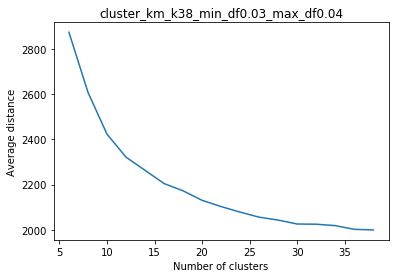


With 6 clusters, the silhouette Coefficient: 0.739
With 8 clusters, the silhouette Coefficient: 0.672
With 10 clusters, the silhouette Coefficient: 0.640
With 12 clusters, the silhouette Coefficient: 0.586
With 14 clusters, the silhouette Coefficient: 0.554
With 16 clusters, the silhouette Coefficient: 0.450
With 18 clusters, the silhouette Coefficient: 0.401
With 20 clusters, the silhouette Coefficient: 0.378
With 22 clusters, the silhouette Coefficient: 0.277
With 24 clusters, the silhouette Coefficient: 0.285
With 26 clusters, the silhouette Coefficient: 0.291
With 28 clusters, the silhouette Coefficient: 0.300
With 30 clusters, the silhouette Coefficient: 0.258
With 32 clusters, the silhouette Coefficient: 0.266
With 34 clusters, the silhouette Coefficient: 0.231
With 36 clusters, the silhouette Coefficient: 0.263
With 38 clusters, the silhouette Coefficient: 0.231


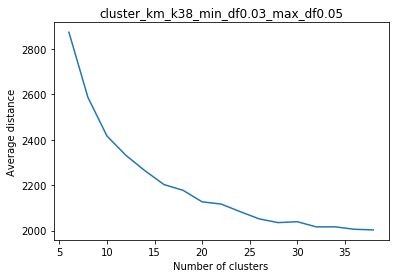


With 6 clusters, the silhouette Coefficient: 0.739
With 8 clusters, the silhouette Coefficient: 0.672
With 10 clusters, the silhouette Coefficient: 0.640
With 12 clusters, the silhouette Coefficient: 0.605
With 14 clusters, the silhouette Coefficient: 0.553
With 16 clusters, the silhouette Coefficient: 0.449
With 18 clusters, the silhouette Coefficient: 0.371
With 20 clusters, the silhouette Coefficient: 0.383
With 22 clusters, the silhouette Coefficient: 0.456
With 24 clusters, the silhouette Coefficient: 0.287
With 26 clusters, the silhouette Coefficient: 0.297
With 28 clusters, the silhouette Coefficient: 0.286
With 30 clusters, the silhouette Coefficient: 0.293
With 32 clusters, the silhouette Coefficient: 0.255
With 34 clusters, the silhouette Coefficient: 0.269
With 36 clusters, the silhouette Coefficient: 0.249
With 38 clusters, the silhouette Coefficient: 0.237


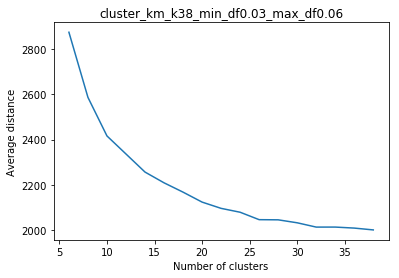


With 6 clusters, the silhouette Coefficient: 0.737
With 8 clusters, the silhouette Coefficient: 0.672
With 10 clusters, the silhouette Coefficient: 0.637
With 12 clusters, the silhouette Coefficient: 0.607
With 14 clusters, the silhouette Coefficient: 0.475
With 16 clusters, the silhouette Coefficient: 0.401
With 18 clusters, the silhouette Coefficient: 0.392
With 20 clusters, the silhouette Coefficient: 0.375
With 22 clusters, the silhouette Coefficient: 0.396
With 24 clusters, the silhouette Coefficient: 0.293
With 26 clusters, the silhouette Coefficient: 0.290
With 28 clusters, the silhouette Coefficient: 0.276
With 30 clusters, the silhouette Coefficient: 0.266
With 32 clusters, the silhouette Coefficient: 0.269
With 34 clusters, the silhouette Coefficient: 0.251
With 36 clusters, the silhouette Coefficient: 0.252
With 38 clusters, the silhouette Coefficient: 0.261


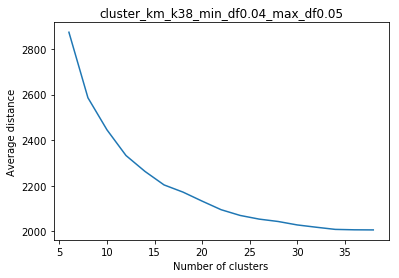


With 6 clusters, the silhouette Coefficient: 0.739
With 8 clusters, the silhouette Coefficient: 0.672
With 10 clusters, the silhouette Coefficient: 0.630
With 12 clusters, the silhouette Coefficient: 0.529
With 14 clusters, the silhouette Coefficient: 0.427
With 16 clusters, the silhouette Coefficient: 0.453
With 18 clusters, the silhouette Coefficient: 0.377
With 20 clusters, the silhouette Coefficient: 0.385
With 22 clusters, the silhouette Coefficient: 0.362
With 24 clusters, the silhouette Coefficient: 0.289
With 26 clusters, the silhouette Coefficient: 0.272
With 28 clusters, the silhouette Coefficient: 0.291
With 30 clusters, the silhouette Coefficient: 0.283
With 32 clusters, the silhouette Coefficient: 0.252
With 34 clusters, the silhouette Coefficient: 0.259
With 36 clusters, the silhouette Coefficient: 0.260
With 38 clusters, the silhouette Coefficient: 0.243


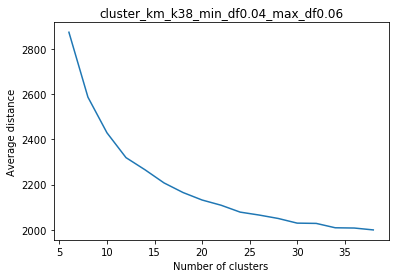


With 6 clusters, the silhouette Coefficient: 0.739
With 8 clusters, the silhouette Coefficient: 0.677
With 10 clusters, the silhouette Coefficient: 0.636
With 12 clusters, the silhouette Coefficient: 0.526
With 14 clusters, the silhouette Coefficient: 0.475
With 16 clusters, the silhouette Coefficient: 0.459
With 18 clusters, the silhouette Coefficient: 0.377
With 20 clusters, the silhouette Coefficient: 0.395
With 22 clusters, the silhouette Coefficient: 0.386
With 24 clusters, the silhouette Coefficient: 0.296
With 26 clusters, the silhouette Coefficient: 0.283
With 28 clusters, the silhouette Coefficient: 0.276
With 30 clusters, the silhouette Coefficient: 0.293
With 32 clusters, the silhouette Coefficient: 0.247
With 34 clusters, the silhouette Coefficient: 0.263
With 36 clusters, the silhouette Coefficient: 0.215
With 38 clusters, the silhouette Coefficient: 0.258


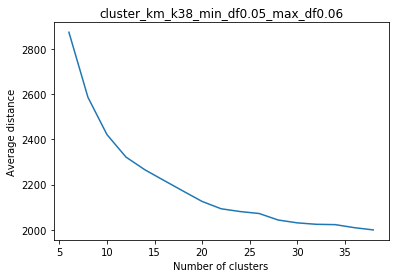

In [217]:
min_df_list = []
max_df_list = []

for i in np.arange(0.01,0.07, 0.01):
    for j in (np.arange(0.01,0.07, 0.01)):
        if (i<j):
            min_df_list.append(i)
            max_df_list.append(j)
        else:
            continue
            
for min_df, max_df in zip(min_df_list, max_df_list):
    combined_vect = TfidfVectorizer(
                        stop_words = stop_words, 
                        ngram_range = (1,3),
                        token_pattern='(?u)\\b[a-zA-z][a-zA-z]+\\b',
                        min_df = min_df,
                        max_df = max_df
    )
    combined_X_train_counts = combined_vect.fit_transform(combined_english_df.text_concat)

    meandist=[]

    for num_clusters in (np.arange(6,40,2)):

        km_combined = KMeans(n_clusters = num_clusters, 
                 init='k-means++')

        km_combined.fit(combined_vocab)

        col_name = 'cluster_km_k%d_min_df%.2f_max_df%.2f' % (num_clusters, min_df, max_df)
        meandist.append(sum(np.min(cdist(combined_vocab, km_combined.cluster_centers_, 'euclidean'), axis=1)))  
        combined_english_df[col_name] = km_combined.labels_
        print("With %d clusters, the silhouette Coefficient: %0.3f" % (num_clusters, metrics.silhouette_score(combined_vocab, km_combined.labels_, metric='sqeuclidean')))

    plt.plot(np.arange(6,40,2), meandist)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average distance')
    plt.title(col_name)
    plt.show()
    print()
          

In [222]:
combined_english_df.drop(['text_concat'],1).head()

,title,provider,cluster_km_k6_min_df0.01_max_df0.02,cluster_km_k8_min_df0.01_max_df0.02,cluster_km_k10_min_df0.01_max_df0.02,cluster_km_k12_min_df0.01_max_df0.02,cluster_km_k14_min_df0.01_max_df0.02,cluster_km_k16_min_df0.01_max_df0.02,cluster_km_k18_min_df0.01_max_df0.02,cluster_km_k20_min_df0.01_max_df0.02,...,cluster_km_k20_min_df0.05_max_df0.06,cluster_km_k22_min_df0.05_max_df0.06,cluster_km_k24_min_df0.05_max_df0.06,cluster_km_k26_min_df0.05_max_df0.06,cluster_km_k28_min_df0.05_max_df0.06,cluster_km_k30_min_df0.05_max_df0.06,cluster_km_k32_min_df0.05_max_df0.06,cluster_km_k34_min_df0.05_max_df0.06,cluster_km_k36_min_df0.05_max_df0.06,cluster_km_k38_min_df0.05_max_df0.06
0,Introduction to Marketing,edx,2,3,6,8,4,7,9,4,...,13,13,15,5,10,13,3,6,17,3
1,Introduction to Computer Science,edx,4,6,4,7,3,10,11,19,...,4,6,3,12,11,12,25,16,23,5
2,Basic Mandarin Chinese – Level 1,edx,4,4,9,9,13,3,0,1,...,16,1,11,13,12,14,15,5,4,11
3,Advanced Biorefinery,edx,3,0,7,6,1,4,7,2,...,7,18,7,6,9,7,10,31,3,7
4,Best Practices for Project Management Success,edx,0,1,1,3,8,11,3,15,...,5,19,1,22,20,11,23,1,25,23


In [223]:
combined_english_df.drop(['text_concat'],1).to_csv('./combined_courses_out_20170602.csv')

## Cosine Similarity

In [271]:
combined_english_df.title.str.contains('test')

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
2187    False
2188    False
2189    False
2190    False
2191    False
2192    False
2193    False
2194    False
2195    False
2196    False
2197    False
2198    False
2199    False
2200    False
2201    False
2202    False
2203    False
2204    False
2205    False
2206    False
2207    False
2208    False
2209    False
2210    False
2211    False
2212    False
2213    False
2214    False
2215    False
2216    False
Name: title, dtype: bool

In [274]:
combined_english_df.ix[570]

title          数据结构与算法设计(下) | Data Structures and Algorithm D...
provider                                                     edx
text_concat    <p>Data structures play a central role in comp...
Name: 570, dtype: object

In [28]:
from sklearn.metrics.pairwise import linear_kernel

In [23]:
cosine_sim_vectorizer = TfidfVectorizer(stop_words = stop_words, 
                             ngram_range = (1,3),
                            token_pattern='(?u)\\b[a-zA-z][a-zA-z]+\\b',
                             min_df = 0.01,
                                max_df = 0.05)

In [88]:
#combined_english_df.reset_index()#.ix[3]
combined_english_df = combined_english_df.reset_index().drop(['index'],1)#.head()

In [90]:
tfidf_matrix = cosine_sim_vectorizer.fit_transform(combined_english_df.text_concat)

In [91]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [191]:
edx_indices = combined_english_df[combined_english_df.provider=='edx'].index
non_edx_indices = combined_english_df[combined_english_df.provider!='edx'].index
non_edx_df = combined_english_df.ix[non_edx_indices]
edx_similarity = cosine_similarities[edx_indices]

In [264]:
def similarity_extract(row):
    similar_indices = cosine_similarities[row['index']][:1332].argsort()[:-5:-1]
    row['course_1_score'] = cosine_similarities[row['index']][similar_indices[0]]
    row['course_1_title'] = combined_english_df[combined_english_df.reset_index()['index'] == similar_indices[0]]['title'].values[0]
    row['course_2_score'] = cosine_similarities[row['index']][similar_indices[1]]
    row['course_2_title'] = combined_english_df[combined_english_df.reset_index()['index'] == similar_indices[1]]['title'].values[0]
    row['course_3_score'] = cosine_similarities[row['index']][similar_indices[2]]
    row['course_3_title'] = combined_english_df[combined_english_df.reset_index()['index'] == similar_indices[2]]['title'].values[0]
    row['course_4_score'] = cosine_similarities[row['index']][similar_indices[3]]
    row['course_4_title'] = combined_english_df[combined_english_df.reset_index()['index'] == similar_indices[3]]['title'].values[0]
    
    return row

In [266]:
edx_course_similarities_df = non_edx_df.reset_index().apply(similarity_extract, axis = 1)

In [267]:
edx_course_similarities_df.to_csv('./edx_course_similarities.csv')

In [195]:
similarity_df = pd.DataFrame()

for idx, row in non_edx_df.iterrows():
    #similarity_df['title'] = row['title']
#     similar_indices = cosine_similarities[idx][:1332].argsort()[:-10:-1]
# #     print (row['title'], row['provider'])
#     #similar_df['title'] = row['title']
#     #similar_df['provider'] = row['provider']
#     similar_course_
#     for i in similar_indices:
#         print (combined_english_df.reset_index().ix[i]['title'])
#     similar_items = [(cosine_similarities[idx][i], combined_english_df['title'][i])
#                      for i in similar_indices]

#     # First item is the item itself, so remove it.
#     # This 'sum' is turns a list of tuples into a single tuple:
#     # [(1,2), (3,4)] -> (1,2,3,4)
#     flattened = sum(similar_items[1:], ())
#     self._r.zadd(self.SIMKEY % row['id'], *flattened)

coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
coursera
c

In [154]:
similarity_df

,title


In [59]:
combined_english_df.reset_index().ix[2216]['title']

'iOS Persistence and Core Data'

In [56]:
similar_indices#.shape

array([2216, 2115, 2167, 2043, 2106, 2164, 2041, 2200, 2138])

In [773]:
# from sklearn.manifold import MDS
# from sklearn.metrics.pairwise import cosine_similarity
# import matplotlib.pyplot as plt
# import matplotlib as mpl

# dist = 1 - cosine_similarity(udacity_coursera_X_train_counts)
# MDS()

# # convert two components as we're plotting points in a two-dimensional plane
# # "precomputed" because we provide a distance matrix
# # we will also specify `random_state` so the plot is reproducible.
# mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

# pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

# xs, ys = pos[:, 0], pos[:, 1]

In [774]:
# udacity_coursera_vocab['xs'] = xs
# udacity_coursera_vocab['ys'] = ys


In [776]:
# udacity_coursera_vocab.head()

,,advanced,allow,analysis,analyze,application,applications,apply,approach,appropriate,assignments,...,web,welcome,work,working,world,write,writing,cluster_km,xs,ys
title,provider,,,,,,,,,,,,,,,,,,,,,
Data Science Specialization,coursera,0.000000,0.050454,0.239089,0.000000,0.0,0.021745,0.017853,0.024348,0.0,0.0,...,0.022843,0.000000,0.031870,0.024051,0.046692,0.0,0.023424,18,0.527600,-0.076525
Positive Psychology,coursera,0.000000,0.000000,0.000000,0.000000,0.0,0.332608,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0,-0.601917,-0.451553
Game Theory,coursera,0.147981,0.000000,0.000000,0.000000,0.0,0.272383,0.000000,0.000000,0.0,0.0,...,0.286140,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,19,-0.360724,-0.187067
Introduction to Psychology,coursera,0.000000,0.000000,0.000000,0.062155,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.092666,0.000000,0.045254,0.0,0.000000,22,-0.390926,0.360193
"Social Norms, Social Change I",coursera,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.033529,0.000000,0.000000,0.000000,0.0,0.000000,15,-0.189441,-0.723001


In [782]:
# import seaborn as sns
# %matplotlib inline 

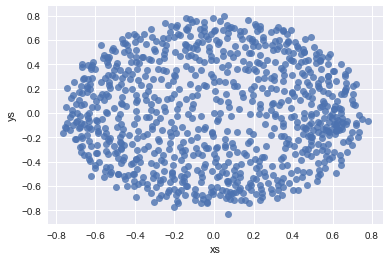

In [788]:
# sns.regplot(data = udacity_coursera_vocab, x = 'xs', y = 'ys', fit_reg = False,)

In [778]:
# label=cluster_names[name], color=cluster_colors[name]

In [620]:
udacity_coursera_vocab.reset_index()[['title','provider','cluster_km']].to_csv('./udacity_coursera_clustered.csv')

## edX
* * *

In [256]:
# edx_df_effort = edx_df.apply(extract_course_effort, axis=1)

In [262]:
# edx_df_effort[['course_id','title','effort','length']].to_csv('./course_length_out.csv')

In [16]:
with urllib.request.urlopen("https://www.edx.org/api/catalog/v2/courses/") as url:
    edx_df = json.loads(url.read().decode())

edx_df = pd.DataFrame(edx_df)
edx_df = edx_df.apply(extract_json, axis=1)
edx_df = edx_df.set_index('title')

In [20]:
# edx_df_english2 = 
edx_df_english = edx_df[edx_df['language']=='en']
edx_df_english['provider'] = 'edx'

/Users/adleyhemphill/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,items,course_id,text_concat,url,language
title,,,,,
Introduction to Marketing,"{'cid': 'v2_full_en:16781', 'current_language'...",course-v1:UBCx+Marketing1x+3T2015,<p>Marketing is a crucial function in all busi...,/course/introduction-marketing-ubcx-marketing1x,en
Introduction to Computer Science,"{'cid': 'v2_full_en:1022', 'current_language':...",course-v1:HarvardX+CS50+X,"<p>This is <strong>CS50x</strong>, Harvard Uni...",/course/introduction-computer-science-harvardx...,en
Basic Mandarin Chinese – Level 1,"{'cid': 'v2_full_en:19576', 'current_language'...",course-v1:MandarinX+MX101x+2T2016,<p>Introductory Mandarin is the first in a ser...,/course/basic-mandarin-chinese-level-1-mandari...,en
Getting Started with Azure App Service: Web Apps,"{'cid': 'v2_full_en:34716', 'current_language'...",course-v1:Microsoft+DEV223x+2T2017,<p>Wondering how to host your apps in the clou...,/course/getting-started-azure-app-service-web-...,en
Leaders of Learning,"{'cid': 'v2_full_en:34741', 'current_language'...",course-v1:HarvardX+GSE2x+2T2017,<p>All of us carry explicit or implicit theori...,/course/leaders-learning-harvardx-gse2x-1,en
Managing Disruptive Change,"{'cid': 'v2_full_en:30881', 'current_language'...",course-v1:RWTHx+MTI001x+2T2017,<p>Disruption is simultaneously the greatest t...,/course/managing-disruptive-change-rwthx-mti001x,en
Science & Cooking: From Haute Cuisine to Soft Matter Science (part 2),"{'cid': 'v2_full_en:32746', 'current_language'...",course-v1:HarvardX+SPU27.2x+2T2017,<p>In Part 2 of Science and Cooking (Part 1 is...,/course/science-cooking-haute-cuisine-soft-har...,en
Demystifying Biomedical Big Data: A User’s Guide,"{'cid': 'v2_full_en:34526', 'current_language'...",course-v1:GeorgetownX+BIOX-201-01x+2T2017_2,<p>With the continuous generation of massive a...,/course/demystifying-biomedical-big-data-users...,en
A System View of Communications: From Signals to Packets (Part 3),"{'cid': 'v2_full_en:29231', 'current_language'...",course-v1:HKUSTx+ELEC1200.3x+2T2017,<p>Have you ever wondered how information is t...,/course/system-view-communications-signals-hku...,en


In [793]:
edx_X_train_counts = count_vect.fit_transform(edx_df_english.text_concat)
col_names = count_vect.get_feature_names()
edx_vocab = pd.DataFrame(edx_X_train_counts.toarray(), columns = col_names).set_index(edx_df_english.index)

In [794]:
km_edx = KMeans(n_clusters=13, init='k-means++', max_iter=100, n_init=1)
km_edx.fit(edx_vocab)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=13, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [795]:
edx_vocab['cluster_km'] = km_edx.labels_

In [412]:
edx_vocab.reset_index()[['title','cluster_km']].sort_values(by='cluster_km', ascending=True)

,title,cluster_km
69,Adaptive Leadership in Development,0
107,Anatomy: Musculoskeletal and Integumentary Sys...,0
597,Solving Public Policy Problems: UC Berkeley’s ...,0
482,MATLAB and Octave for Beginners,0
928,The Beauty and Joy of Computing - AP® CS Princ...,0
210,IMAGE | ABILITY - Visualizing the Unimaginable,0
721,Communication Skills for Bridging Divides,0
1229,"Discrete Time Signals and Systems, Part 2: Fre...",0
718,Robotics: Fundamentals,0
1006,Agile Software Development,0


## Experimental
* * *

In [290]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [445]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD


In [461]:
tfidf_vectorizer = TfidfVectorizer(stop_words = stop_words, 
                             ngram_range = (1,2),
                            smooth_idf=True)

tf_vectorizer = CountVectorizer(stop_words=stop_words, 
                             ngram_range = (1,2))

In [538]:
tf = tfidf_vectorizer.fit_transform(edx_df_english.text_concat)
lda = LatentDirichletAllocation(n_topics=20, 
                                max_iter = 20)
lda.fit(tf)

tfidf_vectorizer._validate_vocabulary()
tf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, 5)

Topic #0:
food access food stem teaching access
Topic #1:
malaria biospecimens stroke different genres human geography
Topic #2:
railway endocrine hazards robotic systems railway systems
Topic #3:
imaging cloud computing html5 los openstack
Topic #4:
louv1 humanism dataflow films dc
Topic #5:
estate real estate life death estate development socially responsible
Topic #6:
422 bloch optical bloch hollywood utm_content 422xmods
Topic #7:
sharks shark steel dog agrimonitor
Topic #8:
course data nbsp design business
Topic #9:
mandarin mandarin chinese phrases sentence prime numbers
Topic #10:
women worked respiratory scramjet cardiovascular rtos
Topic #11:
upright walking locomotion upright walking respiration
Topic #12:
lean canvas systematic scientific ideology common venture ideology common paths
Topic #13:
yoga requirements prior degree requirements prior transferring consult institution
Topic #14:
pmo math226 alternative credit credit project ace alternative
Topic #15:
dog rna tokyo tr

In [539]:
tf = tfidf_vectorizer.fit_transform(udacity_coursera_df.text_concat)
lda = LatentDirichletAllocation(n_topics=20, 
                                max_iter = 20)
lda.fit(tf)

tfidf_vectorizer._validate_vocabulary()
tf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, 5)

/Users/adleyhemphill/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topic #0:
kierkegaard infections bacteria chronic infections вы
Topic #1:
understanding intuitive foundations asset valuation alternative intuitive foundations com h75pzt6
Topic #2:
holocaust prostate cancer prostate jews nordic
Topic #3:
rome buddhist roman sense light fall rome
Topic #4:
ubs enlightenment shiller abuse guest speaker
Topic #5:
mindfulness weight loss constitution amar sexualidad
Topic #6:
diplomacy waste global diplomacy birds english teaching
Topic #7:
dinosaurs dinosaur locomotion adaptations behavioral adaptations
Topic #8:
cryosphere insight planet arctic looking connected rest processes driving
Topic #9:
bitcoin arab marine reptiles marine reptiles
Topic #10:
debt market marketing empower educated product
Topic #11:
data course app ll design
Topic #12:
professor sachs sachs arch aristotle titus
Topic #13:
data models regression teams ll
Topic #14:
deaf american deaf israel deaf community environmental technologies
Topic #15:
common law international criminal egyp

In [482]:
svd = TruncatedSVD()
edx_df_english_svd = svd.fit_transform(tf)

## Unrelated: extract length and effort and load to warehouse

In [58]:
import vertica_python
import os

In [87]:
def extract_course_effort(df):    
    df['course_id'] = df.values[0]['course_id']
    df['effort'] = df.values[0]['effort']
    df['length'] = df.values[0]['length']
    df['subject'] = df.values[0]['subjects'][0]['title']
    return df

In [88]:
edx_df_effort = edx_df.apply(extract_course_effort, axis=1)


In [93]:
edx_df_effort.reset_index()[['course_id','url','subject']].set_index('course_id').to_csv('./edx_course_subject.csv', sep=',')

In [74]:
edx_df_effort.reset_index()[['title','course_id','url','effort','length','text_concat']].set_index('title').to_csv('./edx_course_text.csv', sep=';')

In [69]:
len(edx_df_effort)

1493

In [73]:
edx_df_effort.reset_index()[['title','course_id','url','effort','length','text_concat']].set_index('title')

,course_id,url,effort,length,text_concat
title,,,,,
Introduction to Marketing,course-v1:UBCx+Marketing1x+3T2015,/course/introduction-marketing-ubcx-marketing1x,3-4 hours per week,6 weeks,<p>Marketing is a crucial function in all busi...
Introduction to Computer Science,course-v1:HarvardX+CS50+X,/course/introduction-computer-science-harvardx...,"9 problem sets (10 to 20 hours each), 1 final ...",,"<p>This is <strong>CS50x</strong>, Harvard Uni..."
Basic Mandarin Chinese – Level 1,course-v1:MandarinX+MX101x+2T2016,/course/basic-mandarin-chinese-level-1-mandari...,4 hours per week,6 weeks,<p>Introductory Mandarin is the first in a ser...
Getting Started with Azure App Service: Web Apps,course-v1:Microsoft+DEV223x+2T2017,/course/getting-started-azure-app-service-web-...,2 – 3 hours per week,4 Weeks,<p>Wondering how to host your apps in the clou...
Leaders of Learning,course-v1:HarvardX+GSE2x+2T2017,/course/leaders-learning-harvardx-gse2x-1,2-4 hours per week,6 weeks,<p>All of us carry explicit or implicit theori...
Managing Disruptive Change,course-v1:RWTHx+MTI001x+2T2017,/course/managing-disruptive-change-rwthx-mti001x,6-8 hours per week + exam preparation,6 weeks,<p>Disruption is simultaneously the greatest t...
Science & Cooking: From Haute Cuisine to Soft Matter Science (part 2),course-v1:HarvardX+SPU27.2x+2T2017,/course/science-cooking-haute-cuisine-soft-har...,5 - 7 hours per week,6 week,<p>In Part 2 of Science and Cooking (Part 1 is...
Asociaciones Público Privadas: Implementando Soluciones en Latinoamérica y el Caribe,course-v1:IDBx+IDB8x+2T2017,/course/asociaciones-publico-privadas-idbx-idb...,6 horas a la semana - 6 hours per week,5 semanas / 5 weeks,<p>Las Asociaciones Público Privadas (APPs) se...
Datos para la efectividad de las políticas públicas,course-v1:IDBx+IDB10x+2T2017,/course/datos-para-la-efectividad-de-las-idbx-...,7 horas a la semana,7 semanas,"<p>En esta era de la información, los datos es..."


In [59]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

In [70]:
load_query = """

DROP TABLE IF EXISTS ahemphill.courses_length_effort;
CREATE TABLE IF NOT EXISTS ahemphill.courses_length_effort (
title VARCHAR(555), 
course_id VARCHAR(555), 
url VARCHAR(555),
effort VARCHAR(555),
length VARCHAR(555)
);

COPY ahemphill.courses_length_effort FROM LOCAL '/Users/adleyhemphill/iPython_notebooks/edx_course_length_for_dw.csv' WITH DELIMITER ',';


"""

In [71]:
connection = vertica_python.connect(**conn_info)
cur = connection.cursor('dict')
cur.execute(load_query)
extract = cur.fetchall()   
connection.close()

KeyError: b'F'